In [1]:
import torch
from torch import nn

import torch.multiprocessing as mp

import numpy as np

from tictactoe import TicTacToe, match_players, plot_test_game

from players import RandomPlayer, TablePlayer, MCTSPlayer, DQNPlayer, DoubleDQNPlayer, AlphaZeroPlayer

from episode_server import EpisodeServer

from utils import PriorityMemory, break_episode_to_transitions

from copy import deepcopy

import time

import pickle

In [2]:
env = TicTacToe(3,3,3)
random_player = RandomPlayer(3,3,3)
mcts_player = MCTSPlayer(3,3,3)

In [13]:
match_players(env, mcts_player, mcts_player, 1000)

(0.30522088353413657, -0.27610441767068267)

In [3]:
table_player = TablePlayer(3,3,3, eps=0.2)

In [5]:
epochs = 20
updates_per_epoch = 10000
match_games = 1000

episode_server = EpisodeServer(env, table_player, num_workers=10, max_buffer_size=10000)

episode_server.start()

time.sleep(2)

print("Average rewards against previous version:")
for epoch in range(epochs):
    old_table_player = deepcopy(table_player)
    updates = 0
    while True:
        episodes = episode_server.get_episodes()
        for ep in episodes:
            transitions = break_episode_to_transitions(ep)
            table_player.update_Q(transitions)
            updates += len(transitions)

            if updates > updates_per_epoch:
                break
        if updates > updates_per_epoch:
            break
            
    episode_server.update_player(table_player)
    
    cross_reward, naught_reward = match_players(env, table_player, old_table_player, match_games)
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average rewards against previous version:
Cross: 0.804, naught: 0.430
Cross: 0.591, naught: 0.285
Cross: 0.685, naught: 0.212
Cross: 0.574, naught: 0.285
Cross: 0.516, naught: -0.103
Cross: 0.514, naught: -0.080
Cross: 0.141, naught: -0.061
Cross: 0.406, naught: -0.219
Cross: 0.515, naught: -0.070
Cross: 0.107, naught: -0.073
Cross: 0.540, naught: -0.149
Cross: 0.607, naught: -0.110
Cross: 0.085, naught: -0.107
Cross: 0.152, naught: -0.097
Cross: 0.103, naught: -0.123
Cross: 0.077, naught: -0.127
Cross: 0.108, naught: -0.076
Cross: 0.127, naught: -0.100
Cross: 0.097, naught: -0.080
Cross: 0.144, naught: -0.124


In [6]:
table_player.eps = 0

In [7]:
match_players(env, table_player, random_player, 1000)

(0.9849397590361445, 0.9236947791164659)

In [8]:
match_players(env, table_player, mcts_player, 1000)

(0.6696787148594376, 0.11947791164658635)

In [8]:
env = TicTacToe(4,4,4)
random_player = RandomPlayer(4,4,4)
mcts_player = MCTSPlayer(4,4,4)
table_player = TablePlayer(4,4,4, eps=0.2)

In [9]:
epochs = 20
updates_per_epoch = 10000
match_games = 1000

episode_server = EpisodeServer(env, table_player, num_workers=10, max_buffer_size=10000)

episode_server.start()

print("Average rewards against previous version:")
for epoch in range(epochs):
    old_table_player = deepcopy(table_player)
    updates = 0
    while True:
        episodes = episode_server.get_episodes()
        for ep in episodes:
            transitions = break_episode_to_transitions(ep)
            table_player.update_Q(transitions)
            updates += len(transitions)

            if updates > updates_per_epoch:
                break
        if updates > updates_per_epoch:
            break
            
    episode_server.update_player(table_player)
    
    cross_reward, naught_reward = match_players(env, table_player, old_table_player, match_games)
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average rewards against previous version:
Cross: 0.060, naught: -0.040
Cross: 0.016, naught: -0.045
Cross: 0.053, naught: -0.055
Cross: 0.020, naught: -0.082
Cross: 0.086, naught: -0.056
Cross: 0.040, naught: -0.045
Cross: 0.049, naught: -0.019
Cross: 0.021, naught: -0.061
Cross: 0.095, naught: -0.035
Cross: 0.091, naught: -0.060
Cross: 0.091, naught: -0.083
Cross: 0.075, naught: -0.092
Cross: 0.068, naught: -0.060
Cross: 0.037, naught: -0.013
Cross: 0.028, naught: -0.023
Cross: 0.039, naught: -0.064
Cross: 0.095, naught: -0.077
Cross: 0.120, naught: -0.098
Cross: 0.175, naught: -0.046
Cross: 0.193, naught: 0.022


In [15]:
table_player.eps = 0

In [23]:
match_players(env, random_player, random_player, 1000)

(0.04618473895582329, -0.07730923694779115)

In [16]:
match_players(env, table_player, random_player, 1000)

(0.10441767068273093, -0.06024096385542168)

In [19]:
match_players(env, mcts_player, random_player, 1000)

(0.9166666666666669, 0.8102409638554217)

In [24]:
match_players(env, table_player, mcts_player, 1000)

(-0.8092369477911646, -0.9066265060240966)

In [9]:
DEVICE = 'cuda:0'

In [10]:
env = TicTacToe(3,3,3)
random_player = RandomPlayer(3,3,3)
mcts_player = MCTSPlayer(3,3,3)

In [11]:
dqn_player = DQNPlayer(3, 3, 3, gamma=1.0).to(DEVICE)

In [12]:
epochs = 20
updates_per_epoch = 500
batch_size = 256
match_games = 1000

episode_server = EpisodeServer(env, dqn_player, num_workers=10, max_buffer_size=10000)
memory = PriorityMemory(size=5000)

dqn_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_dqn_player = deepcopy(dqn_player)
    dqn_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = break_episode_to_transitions(ep)
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = dqn_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    episode_server.update_player(dqn_player)
    
    cross_reward, naught_reward = match_players(env, dqn_player, old_dqn_player, match_games)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.01597839780151844
Average rewards against previous version:
Cross: 0.912, naught: -0.632
Average loss: 0.017512112855911255
Average rewards against previous version:
Cross: -0.617, naught: 0.743
Average loss: 0.01758529432117939
Average rewards against previous version:
Cross: 0.712, naught: 0.646
Average loss: 0.0216546468436718
Average rewards against previous version:
Cross: 0.835, naught: 0.619
Average loss: 0.023917842656373978
Average rewards against previous version:
Cross: 0.708, naught: -0.840
Average loss: 0.018032940104603767
Average rewards against previous version:
Cross: 0.735, naught: 0.469
Average loss: 0.030377376824617386
Average rewards against previous version:
Cross: 0.821, naught: -0.640
Average loss: 0.013129325583577156
Average rewards against previous version:
Cross: 0.766, naught: 0.488
Average loss: 0.015056565403938293
Average rewards against previous version:
Cross: 0.704, naught: 0.617
Average loss: 0.0109599893912673
Average rewards agains

In [13]:
dqn_player.eps = 0

In [14]:
match_players(env, dqn_player, random_player, match_games)

(0.9779116465863452, 0.681726907630522)

In [15]:
match_players(env, dqn_player, mcts_player, match_games)

(0.2961847389558233, -0.606425702811245)

In [3]:
DEVICE = 'cuda:0'

In [4]:
env = TicTacToe(4,4,4)
random_player = RandomPlayer(4,4,4)
mcts_player = MCTSPlayer(4,4,4)

In [5]:
double_dqn_player = DoubleDQNPlayer(4, 4, 4, gamma=1.0, net_config={
    "type": "dueling_dqn"
}).to(DEVICE)

In [6]:
epochs = 20
updates_per_epoch = 100
batch_size = 256
match_games = 1000

episode_server = EpisodeServer(env, double_dqn_player, num_workers=10, max_buffer_size=10000)
memory = PriorityMemory(size=5000)

double_dqn_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_double_dqn_player = deepcopy(double_dqn_player)
    double_dqn_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = break_episode_to_transitions(ep)
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = double_dqn_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    double_dqn_player.update_target_dqn()
    episode_server.update_player(double_dqn_player)
    
    cross_reward, naught_reward = match_players(env, double_dqn_player, old_double_dqn_player, match_games)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.20358364284038544
Average rewards against previous version:
Cross: 0.774, naught: -0.697
Average loss: 0.04777352884411812
Average rewards against previous version:
Cross: 0.626, naught: 0.473
Average loss: 0.02711956575512886
Average rewards against previous version:
Cross: 0.247, naught: 0.812
Average loss: 0.02583559975028038
Average rewards against previous version:
Cross: 0.692, naught: 0.443
Average loss: 0.026085279881954193
Average rewards against previous version:
Cross: 0.432, naught: -0.382
Average loss: 0.022683538496494293
Average rewards against previous version:
Cross: -0.032, naught: 0.782
Average loss: 0.021792465820908546
Average rewards against previous version:
Cross: 0.494, naught: 0.012
Average loss: 0.01602659747004509
Average rewards against previous version:
Cross: -0.321, naught: 0.393
Average loss: 0.019210465252399445
Average rewards against previous version:
Cross: 0.548, naught: -0.235
Average loss: 0.022223299369215965
Average rewards agai

In [7]:
double_dqn_player.eps = 0

In [9]:
match_players(env, double_dqn_player, random_player, match_games)

(0.7048192771084337, 0.34437751004016065)

In [10]:
match_players(env, double_dqn_player, mcts_player, match_games)

(-0.4457831325301205, -0.8775100401606425)

In [2]:
DEVICE = 'cuda:0'

In [3]:
env = TicTacToe(3,3,3)
random_player = RandomPlayer(3,3,3)
mcts_player = MCTSPlayer(3,3,3)

In [4]:
alphazero_player = AlphaZeroPlayer(3,3,3,num_simulations=100, eps=0.2, exploration_parameter=0.5).to(DEVICE)

In [5]:
epochs = 5
updates_per_epoch = 300
batch_size = 256
match_games = 100

episode_server = EpisodeServer(env, alphazero_player, num_workers=10, max_buffer_size=10000, zero_mode=True)
memory = PriorityMemory(size=5000)

alphazero_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_alphazero_player = deepcopy(alphazero_player)
    alphazero_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = ep
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = alphazero_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    episode_server.update_player(alphazero_player)
    
    cross_reward, naught_reward = match_players(env, alphazero_player, old_alphazero_player, match_games)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.3264520764350891
Average rewards against previous version:
Cross: 0.302, naught: -0.073
Average loss: -0.19637233018875122
Average rewards against previous version:
Cross: 0.521, naught: -0.188
Average loss: -0.2983544170856476
Average rewards against previous version:
Cross: 0.146, naught: -0.250
Average loss: -0.34474924206733704
Average rewards against previous version:
Cross: 0.323, naught: -0.260
Average loss: -0.35527756810188293
Average rewards against previous version:
Cross: 0.260, naught: -0.271


In [8]:
alphazero_player.eps = 0

In [9]:
match_players(env, alphazero_player, random_player, match_games)

(0.9895833333333334, 0.875)

In [10]:
match_players(env, alphazero_player, mcts_player, match_games)

(0.3645833333333333, 0.0625)

In [2]:
DEVICE = 'cuda:0'

In [3]:
env = TicTacToe(4,4,4)
random_player = RandomPlayer(4,4,4)
mcts_player = MCTSPlayer(4,4,4)

In [4]:
num_simulations = 100
alphazero_player = AlphaZeroPlayer(
    4,4,4,num_simulations=num_simulations, eps=0.2, exploration_parameter=0.5
).to(DEVICE)

In [5]:
epochs = 20
updates_per_epoch = 300
batch_size = 256
match_games = 100

episode_server = EpisodeServer(env, alphazero_player, num_workers=12, max_buffer_size=10000, zero_mode=True)
memory = PriorityMemory(size=5000)

alphazero_player.configure_optimizer(lr=3e-4)

episode_server.start()

time.sleep(2)

for epoch in range(epochs):
    old_alphazero_player = deepcopy(alphazero_player)
    alphazero_player.train()

    episodes = episode_server.get_episodes()
    for ep in episodes:
        transitions = ep
        transitions_with_losses = [
            (tr, float("inf")) for tr in transitions
        ]
        memory.put(transitions_with_losses)

    losses = []
    for _ in range(updates_per_epoch):
        transitions = memory.get(batch_size)
        _losses = alphazero_player.update_Q(transitions)

        transitions_with_losses = [
            (tr, _loss) for tr, _loss in zip(transitions, _losses)
        ]
        memory.put(transitions_with_losses)

        losses.append(_losses.mean())

    losses = np.array(losses)
    print(f"Average loss: {losses.mean()}")
            
    episode_server.update_player(alphazero_player)
    
    ##reducing simulations number for validation
    alphazero_player.set_params(num_simulations=5)
    old_alphazero_player.set_params(num_simulations=5)
    
    cross_reward, naught_reward = match_players(env, alphazero_player, old_alphazero_player, match_games)
    
    alphazero_player.set_params(num_simulations=num_simulations)
    print("Average rewards against previous version:")
    print(f"Cross: {cross_reward:.3f}, naught: {naught_reward:.3f}")
        
episode_server.stop()

Average loss: 0.878789484500885
Average rewards against previous version:
Cross: -0.115, naught: -0.104
Average loss: 0.41538265347480774
Average rewards against previous version:
Cross: 0.094, naught: -0.104
Average loss: 0.28180819749832153
Average rewards against previous version:
Cross: 0.188, naught: -0.135
Average loss: 0.17606939375400543
Average rewards against previous version:
Cross: 0.208, naught: -0.229
Average loss: 0.07803648710250854
Average rewards against previous version:
Cross: 0.292, naught: -0.302
Average loss: 0.03610307723283768
Average rewards against previous version:
Cross: 0.167, naught: -0.083
Average loss: 0.02060316503047943
Average rewards against previous version:
Cross: 0.135, naught: -0.042
Average loss: 0.024007532745599747
Average rewards against previous version:
Cross: 0.083, naught: -0.062
Average loss: -0.002476491965353489
Average rewards against previous version:
Cross: 0.104, naught: -0.073
Average loss: -0.025719977915287018
Average rewards a

In [7]:
alphazero_player.set_params(eps=0.0)

In [8]:
match_players(env, alphazero_player, random_player, match_games)

(0.9270833333333334, 0.7708333333333334)

In [9]:
match_players(env, alphazero_player, mcts_player, match_games)

(0.15625, -0.041666666666666664)

In [14]:
alphazero_player.reset()
alphazero_player = alphazero_player.cpu().eval()

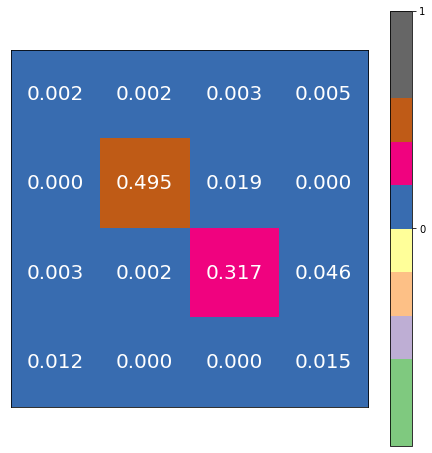

0 (0, 0) 0.0018181818181818182
1 (0, 1) 0.0012121212121212121
2 (0, 2) 0.0018181818181818182
3 (0, 3) 0.0030303030303030303
4 (1, 0) 0.00030303030303030303
5 (1, 1) 0.626969696969697
6 (1, 2) 0.013636363636363636
7 (1, 3) 0.00030303030303030303
8 (2, 0) 0.0027272727272727275
9 (2, 1) 0.0015151515151515152
10 (2, 2) 0.27515151515151515
11 (2, 3) 0.04454545454545455
12 (3, 0) 0.010303030303030303
13 (3, 1) 0.0009090909090909091
14 (3, 2) 0.00030303030303030303
15 (3, 3) 0.015454545454545455


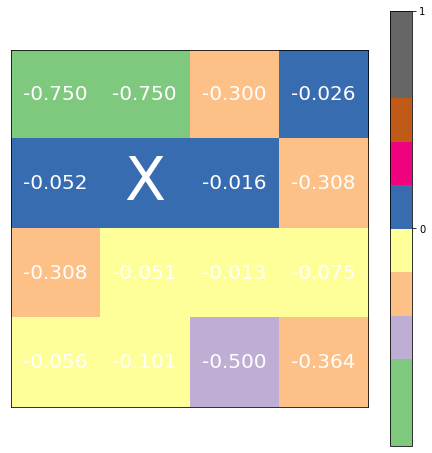

0 (0, 0) -0.22222222222222227
1 (0, 1) -0.5714285714285714
2 (0, 2) -0.13513513513513514
3 (0, 3) -0.058095238095238116
4 (1, 0) -0.0813008130081301
5 (1, 2) -0.06388206388206388
6 (1, 3) -0.30769230769230765
7 (2, 0) -0.30769230769230776
8 (2, 1) -0.06716417910447763
9 (2, 2) -0.062248995983935754
10 (2, 3) -0.0851063829787234
11 (3, 0) -0.06118143459915611
12 (3, 1) -0.10126582278481014
13 (3, 2) -0.5
14 (3, 3) -0.36363636363636365


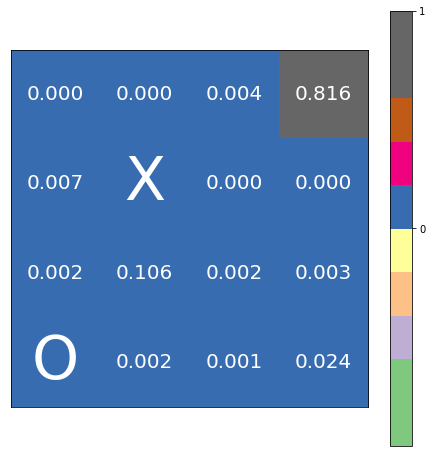

0 (0, 0) 0.0
1 (0, 1) 0.0003436426116838488
2 (0, 2) 0.0027491408934707906
3 (0, 3) 0.849828178694158
4 (1, 0) 0.004810996563573883
5 (1, 2) 0.001718213058419244
6 (1, 3) 0.0003436426116838488
7 (2, 0) 0.001718213058419244
8 (2, 1) 0.10412371134020619
9 (2, 2) 0.001718213058419244
10 (2, 3) 0.006872852233676976
11 (3, 1) 0.001718213058419244
12 (3, 2) 0.0006872852233676976
13 (3, 3) 0.02336769759450172


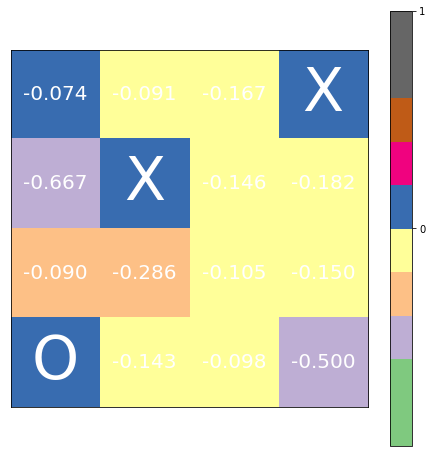

0 (0, 0) -0.08778877887788776
1 (0, 1) -0.09638554216867469
2 (0, 2) -0.16666666666666669
3 (1, 0) -0.6666666666666666
4 (1, 2) -0.14583333333333331
5 (1, 3) -0.18181818181818188
6 (2, 0) -0.0953846153846154
7 (2, 1) -0.17647058823529413
8 (2, 2) -0.1101694915254237
9 (2, 3) -0.1627906976744186
10 (3, 1) -0.0727272727272727
11 (3, 2) -0.10389610389610389
12 (3, 3) -0.5


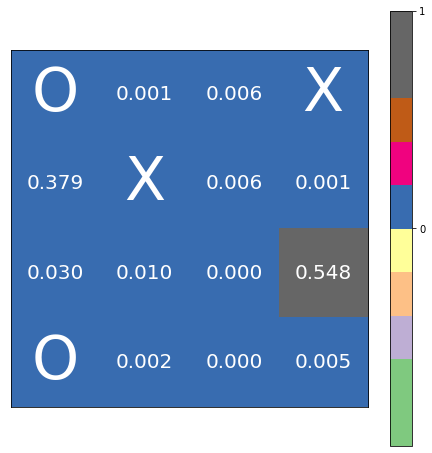

0 (0, 1) 0.001994415636218588
1 (0, 2) 0.005185480654168329
2 (1, 0) 0.3677702433187076
3 (1, 2) 0.011567610690067811
4 (1, 3) 0.0011966493817311527
5 (2, 0) 0.03909054646988432
6 (2, 1) 0.01316314319904268
7 (2, 2) 0.0
8 (2, 3) 0.5528520143597926
9 (3, 1) 0.0015955325089748703
10 (3, 2) 0.0
11 (3, 3) 0.005584363781412046


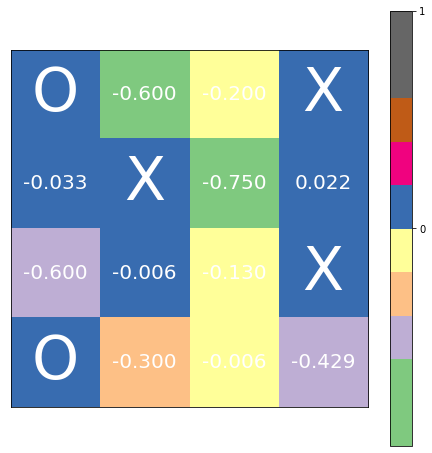

0 (0, 1) -0.6
1 (0, 2) -0.2
2 (1, 0) -0.03278688524590163
3 (1, 2) -0.75
4 (1, 3) 0.012847965738758035
5 (2, 0) -0.6
6 (2, 1) -0.006451612903225808
7 (2, 2) -0.13043478260869562
8 (3, 1) -0.30000000000000004
9 (3, 2) -0.006369426751592337
10 (3, 3) -0.4285714285714286


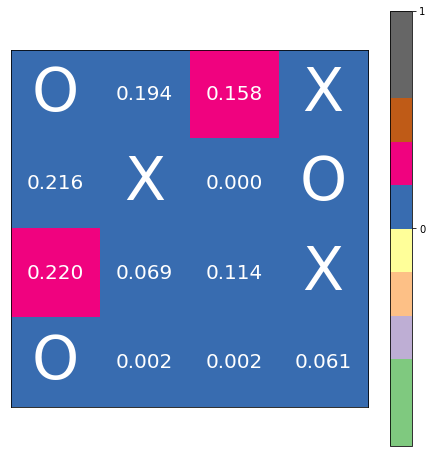

0 (0, 1) 0.14666666666666667
1 (0, 2) 0.13714285714285715
2 (1, 0) 0.21619047619047618
3 (1, 2) 0.028095238095238097
4 (2, 0) 0.21333333333333335
5 (2, 1) 0.08285714285714285
6 (2, 2) 0.11190476190476191
7 (3, 1) 0.0014285714285714286
8 (3, 2) 0.0019047619047619048
9 (3, 3) 0.060476190476190475


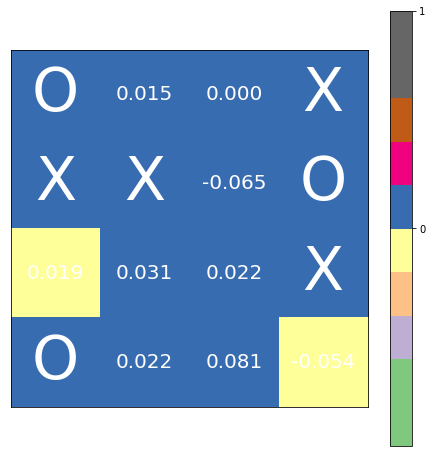

0 (0, 1) -0.013333333333333324
1 (0, 2) -0.01694915254237287
2 (1, 2) -0.06451612903225806
3 (2, 0) 0.0175438596491228
4 (2, 1) 0.028622540250447234
5 (2, 2) 0.021645021645021644
6 (3, 1) 0.022012578616352176
7 (3, 2) 0.03355704697986574
8 (3, 3) -0.05405405405405406


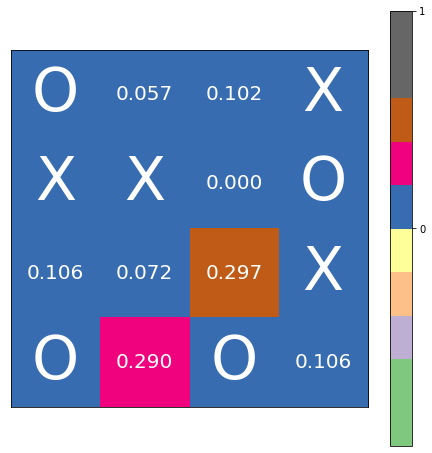

0 (0, 1) 0.052941176470588235
1 (0, 2) 0.09117647058823529
2 (1, 2) 0.0
3 (2, 0) 0.08705882352941176
4 (2, 1) 0.06294117647058824
5 (2, 2) 0.2888235294117647
6 (3, 1) 0.3170588235294118
7 (3, 3) 0.1


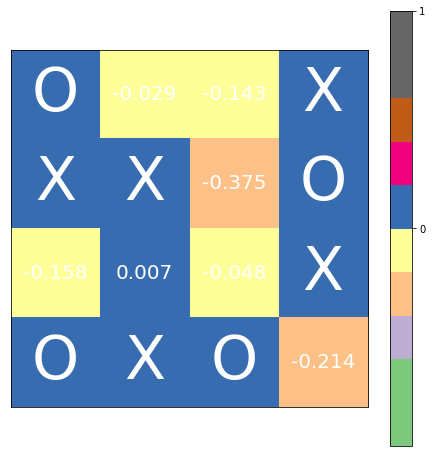

0 (0, 1) -0.03125
1 (0, 2) -0.14285714285714285
2 (1, 2) -0.375
3 (2, 0) -0.15789473684210525
4 (2, 1) 0.005583126550868467
5 (2, 2) -0.04761904761904763
6 (3, 3) -0.21428571428571427


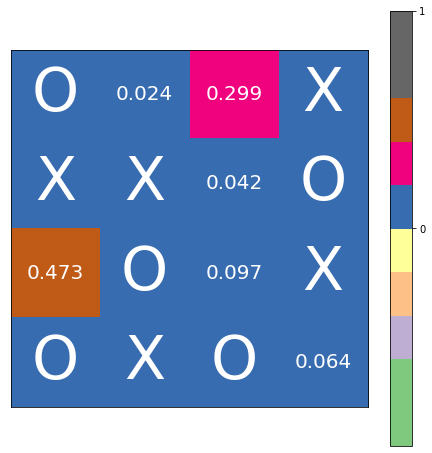

0 (0, 1) 0.01769230769230769
1 (0, 2) 0.3069230769230769
2 (1, 2) 0.03923076923076923
3 (2, 0) 0.48
4 (2, 2) 0.09307692307692307
5 (3, 3) 0.06307692307692307


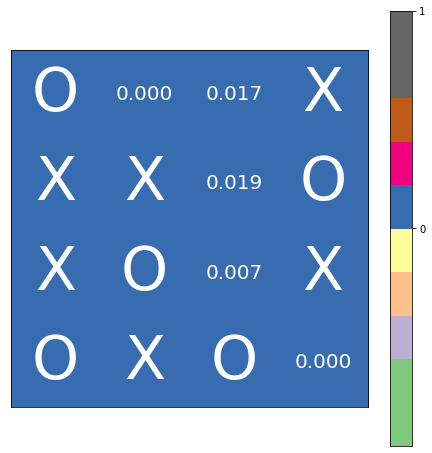

0 (0, 1) 0.0
1 (0, 2) 0.010909090909090917
2 (1, 2) 0.014251781472684058
3 (2, 2) 0.005617977528089888
4 (3, 3) 0.0


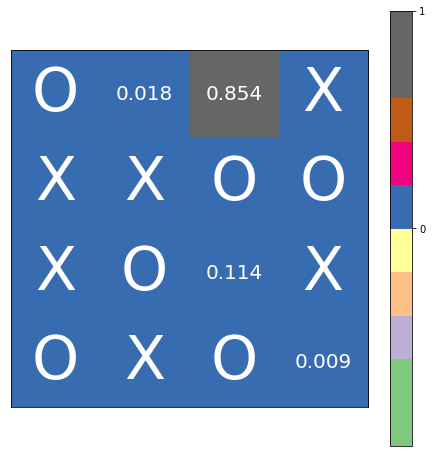

0 (0, 1) 0.012461059190031152
1 (0, 2) 0.8712357217030114
2 (2, 2) 0.10799584631360332
3 (3, 3) 0.008307372793354102


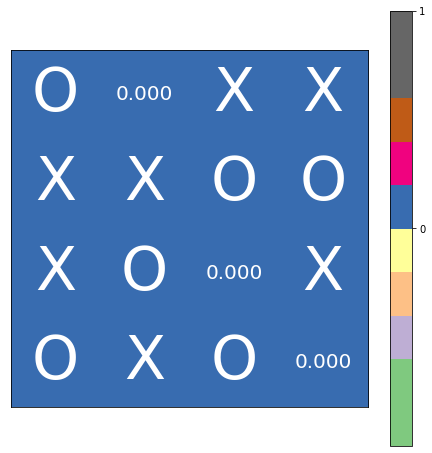

0 (0, 1) 0.0
1 (2, 2) 0.0
2 (3, 3) 0.0


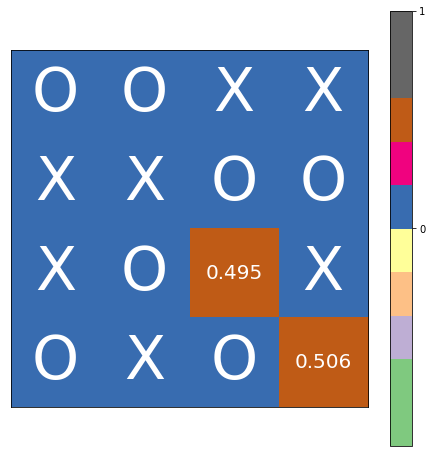

0 (2, 2) 0.4917218543046358
1 (3, 3) 0.5082781456953642


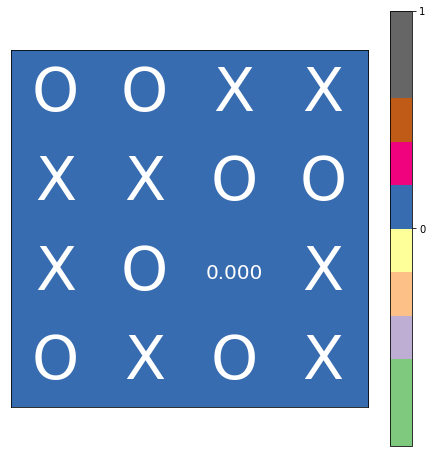

0 (2, 2) 0.0


In [15]:
with torch.no_grad():
    plot_test_game(env, alphazero_player, mcts_player, random_naughts=False)

P.S. При вызове alphazero_player.get_Q заново запускаются MCTS симуляции. Так как этот метод зовётся в функции отрисовки несколько раз, ход и максимум очков на картинке немного не совпадают. Для alphazero get_Q выдаёт policy(a|s), а не Q(a|s).